## Hi Guys! Today, I have chosen an important problem statement to work upon. Let me break it down into simple words, and you will soon understand its importance.

### -  Financial institutions invest a ton of money for constructing credit risk analysis models to determine the probability of default of a potential borrower. The models provide information on the level of a borrower's credit risk at any particular time. 

### -  Some of you might be wondering what "credit" is. Well here's come the definition:

<div style="width:100%;text-align: center;"> <img align=middle src="https://www.greenbiz.com/sites/default/files/2020-09/definition_conceptart.jpg" alt="Heat beating" style="height:300px;margin-top:3rem;"> </div>

### <span style="color:red;"> - "Credit is the ability to borrow money or access goods or services with the understanding that you'll pay later." </span>

### <span style="color:blue;"> - "Creditworthiness is how a lender determines that you will default on your debt obligations, or how worthy you are to receive new credit. Your creditworthiness is what creditors look at before they approve any new credit to you." </span>


### Credit risks are a commonly observed phenomenon in **areas of finance** that relate to mortgages, credit cards, and other kinds of loans. There is always a probability that the borrower may not get back with the amount. Traditionally, it refers to the risk that a lender may not receive the owed principal and interest, which results in an **interruption of cash flows** and **increased costs** for collection.

### Hence properly assessing and managing credit risk can **lessen** the severity of a **loss**.

# Agenda:

So it is important that when a borrower applies for a loan, the lender or the issuer must establish and examine the borrower’s ability to repay the loan. So in this notebook, I will be doing the following stuff:

1. Exploring the Dataset(**EDA**)
2. Applying **KNN SMOTE** as an **Oversampling** Technique
3. Test boosting machine learning models using **Cross Validation** technique
4. **Hyperparameter tune** to obtain the best model and construct the **pipeline**
5. **Evaluate** the best model with the help of relevant **Metrics** 
6. **Pickling** the best pipeline 
7. Creating an **UI**(User Interface) with the help of **Streamlit** 
8. **Deployment** on **Heroku** platform
9. A **sample prediction** will be made to test the application

The 7th and 8th steps will be shown and explained with the help of screenshots.

### - Importing the necessary header files:

In [ ]:
## Basic Libraries:
import pandas as pd
pd.options.display.max_colwidth=150   ## this is used to set the column width.

## Note: Other available must know options are:
# pd.options.display.max_rows=x  ## controls the max rows to be displayed on screen
# pd.options.display.max_columns=x  ## controls the max columns to be displayed on screen
# pd.options.display.precision=x  ## controls the precision of each floating points to be displayed on screen
# pd.options.display.float_format = '{:.2f}%'.format  ## controls the format of displaying numbers on screen. 
                                                      ## For eg.{$(:,.2f)} can be used for currency

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import time
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 

plt.style.use('fivethirtyeight') ## Setting the Style

## For making sample data:
from sklearn.datasets import make_classification

## For Preprocessing: 
from sklearn.compose import ColumnTransformer,make_column_selector
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, RepeatedKFold,RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# from sklearn.base import TransformerMixin,BaseEstimator

## Using imblearn library:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

## Using msno Library for Missing Value analysis:
import missingno as msno

## For Metrics:
from sklearn.metrics import plot_precision_recall_curve,accuracy_score,matthews_corrcoef
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

## For Machine Learning Models:
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

## For Pickling:
import pickle

In [ ]:
import sklearn
sklearn.__version__

In [ ]:
## Setting the seed to allow reproducibility
np.random.seed(31415)

# 1. Exploring the Dataset(EDA)

## About the Dataset:

### Link to the dataset: https://www.kaggle.com/datasets/laotse/credit-risk-dataset

### The dataset consists of the following features and target variable is "**loan_status**":

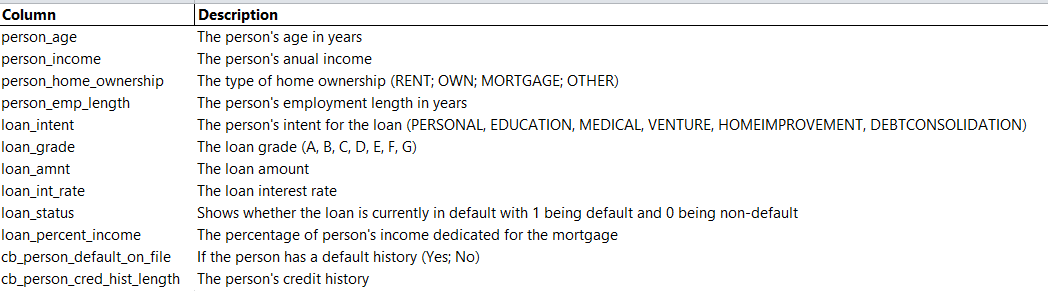

### - Reading the dataset:

In [ ]:
df = pd.read_csv("/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv")
df.head()

In [ ]:
# ## Using some sample of the data:
# df=df.sample(n=1000).reset_index(drop=True)

In [ ]:
df.shape[0],df.shape[1]

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
## Checking for Duplicates
dups = df.duplicated()
dups.value_counts() #There are 165 Duplicated rows

In [ ]:
## Removing the Duplicates
print(f"Shape of Data before removing duplicates -----> ({df.shape[0]},{df.shape[1]}) \n")
df.drop_duplicates(inplace=True)
print(f"Shape of Data after removing duplicates -----> ({df.shape[0]},{df.shape[1]})")

In [ ]:
ccol=df.select_dtypes(include=["object"]).columns
ncol=df.select_dtypes(include=["int","float"]).columns

print("The number of Categorical columns are:",len(ccol))
print("The number of Numerical columns are:",len(ncol))

#### - Printing the different columns with their cardinality (number of unique elements in each column):

In [ ]:
print("The NUMERICAL columns are:\n")
for i in ncol:
    print("->",i,"-",df[i].nunique())
    
print("\n---------------------------\n")
print("The CATEGORICAL columns are:\n")
for i in ccol:
    print("->",i,"-",df[i].nunique())

#### **'loan_int_rate' describes the Interest Rate offered on Loans by Banks or any financial institution. There is no fixed value as it varies from bank to bank. Hence I am removing this column for our analysis.**

In [ ]:
df.drop(['loan_int_rate'],axis=1,inplace=True)

#### - Analysing the categorical variables:

In [ ]:
df["loan_intent"].unique()

In [ ]:
df.columns

#### - Analysing the Target variable i.e. 'loan_status':

In [ ]:
df["loan_status"].value_counts(normalize=True)

#### The Data is highly **IMBALANCED**. We will deal with oversampling techniques like KNN-SMOTE to solve this issue.

### - Checking for Missing Data:

#### Missing data, or missing values, occur when you don’t have data stored for certain variables or participants. Data can go missing due to incomplete data entry, equipment malfunctions, lost files, and many other reasons.

#### There are typically 3 types of missing values:

**1. Missing completely at random (MCAR)**

**2. Missing at random (MAR)**

**3. Missing not at random (MNAR)**

#### **Problems:**

#### Missing data are problematic because, depending on the type, they can sometimes cause sampling bias. This means your results may not be generalizable outside of your study because your data come from an unrepresentative sample.

In [ ]:
## Checking for Missing values:
df.isnull().any()

In [ ]:
df.isna().sum()

In [ ]:
mn=df.isna().sum()
mn=pd.DataFrame(mn,columns=["missing_count"]).reset_index()
mn.columns=["columns_names","missing_count"]

sns.set_theme(style="darkgrid")
plt.figure(figsize=(15,10))
plots=sns.barplot(x=mn.columns_names,y=mn.missing_count)
# Iterating over the bars one-by-one
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=12, xytext=(0, 8),
                   textcoords='offset points')
plt.xticks(rotation=45) #Rotating the Label
plt.title("Missing values in every column.",size=25,weight="bold") #Title of the plot
plt.xlabel("Columns",fontsize=20) #Title of x-axis
plt.ylabel("Missing_Count",fontsize=20)
plt.tick_params(labelsize=10) #Varying label size
plt.tight_layout()

### Using missing number visualiser to review the missing data:

#### - On the **left** side of the plot, the y-axis scale ranges from 0.0 to 1.0, where 1.0 represents 100% data completeness. If the bar is less than this, it indicates that we have missing values within that column.

#### - On the **right** side of the plot, the scale is measured in index values. With the top right representing the maximum number of rows within the dataframe.

#### - Along the **top** of the plot, there are a series of numbers that represent the total count of the non-null values within that column.

In [ ]:
msno.bar(df)

#### - The matrix plot is a great tool if you are working with depth-related data or time-series data. It provides a colour fill for each column. When data is present, the plot is shaded in grey (or your colour of choice), and when it is absent the plot is displayed in white.

In [ ]:
msno.matrix(df)

#### - The heatmap is used to identify correlations of the nullity between each of the different columns. 

#### - Here no correlation is detected between columns having missing values.

In [ ]:
msno.heatmap(df)

In [ ]:
## Missing values in each target class:
#l=df.groupby(["loan_status"])["loan_int_rate"].apply(lambda x:x.isnull().sum())
p=df.groupby(["loan_status"])["person_emp_length"].apply(lambda x:x.isnull().sum())

fig,ax=plt.subplots(1,1,figsize=(8,8))
# ax[0].set_title("Missing values in loan_int_rate")
# ax[0].pie(l.values, labels=l.index, colors=sns.color_palette('bright'), autopct='%.0f%%')

ax.set_title("Missing values in person_emp_length")
ax.pie(p.values, labels=p.index, colors=sns.color_palette('cool'), autopct='%.0f%%')
fig.show()

#### NOTE: EVERY PREPROCESSING TECHNIQUE IS DONE ONLY ON THE TRAIN SET. SO SPLITTING IS MANDATORY BEFORE OUTLIER REMOVAL, MISSING VALUES HANDLING, OVERSAMPLING, ETC...

#### - Time to handle the missing values. First we will split the data:

In [ ]:
# X and y will represent the entire training data
# X_test and y_test will be the sample data for model evaluation

X, X_test, y, y_test = train_test_split(df.drop('loan_status', axis=1), df['loan_status'],
                                        random_state=0,  test_size=0.2, stratify=df['loan_status'],
                                        shuffle=True)

#### - We have stratified sampled the data (checking the proportion of the target variable):

In [ ]:
y.value_counts(normalize=True)   #Note that the proportion remains the same because of stratify.

In [ ]:
y_test.value_counts(normalize=True)

#### The proportion is preserved!

In [ ]:
## Checking for missing values in train data:
(X.shape[0]-X.dropna().shape[0])/X.shape[0]*100
## There are 12% missing data in the train set

In [ ]:
#To print the number of unique values:
for col in X:
    print(col, '--->', X[col].nunique())
    if X[col].nunique()<20:
        print(X[col].value_counts(normalize=True)*100)
    print()

### **Removing Outliers** based on Domain Knowledge:

#### - Using common sense, we can exclude rows whose age is >80.

In [ ]:
X.loc[X['person_age']>=80, :]  

In [ ]:
X.shape   ## shape before removal

In [ ]:
X = X.loc[X['person_age']<80, :]

In [ ]:
X.shape  ## shape after removal

#### - We can also exclude rows whose work experience is >60 (Assuming average Upper bound of employement).

In [ ]:
X.loc[X['person_emp_length']>=60, :]

In [ ]:
X = X.loc[X['person_emp_length']<60, :]

In [ ]:
# Since we've removed some data from X, we need to pass on these updations to y as well,
# as y doesn't know some of its corresponding X's have been deleted.
y = y[X.index]

#### - Checking the distribution of the Target variable:

In [ ]:
y.value_counts()

# 2. Creating the Best Pipeline:

#### - The Main Pipeline will be made of **two** parts:

- Preprocessing for **NUMERICAL VARIABLES**:

1. **Iterative imputer** - To handle missing values    
2. **SMOTE** - To handle imbalance in the dataset
3. **Scaling** - To maintain the scale among features

- Preprocessing for **CATEGORICAL VARIABLES**:

1. **One Hot Encoder** - To encode each categoric for model interpretability

#### - **Visualising the Pipeline**:

#### - The bottom code snippet is a small picture for something big to come. 

**NOTE:** It is always important for any Data Scientist to try out their methods and solutions on smaller data(readily available data), before they can actually dwelve into their own dataset. This will make it easier to debug code.

#### - Sample Test Code:

In [ ]:
# ## Making artificial data with the help of sklearn's make_classification method:
# X,y=make_classification(10000,20,n_classes=2,weights=[0.75])

# ## Gives count of each target's class:
# uni,cnt=np.unique(y,return_counts=True)
# for i,(j,k) in enumerate(zip(uni,cnt)):
#     print(j,"--",k)

# X=pd.DataFrame(X)

# ## Function to select random indexes:
# def create_index(nrows):
#     l=np.random.randint(0,nrows,50)
#     return l

# ## Making some rows as Null.
# for i in range(X.shape[1]):
#     X.iloc[create_index(X.shape[0]),i]=None
    
# ## To check the null values in every column:
# X.isnull().sum()

# ## Splitting:
# X_train,X_test,y_train,y_test=train_test_split(X,y)

# ## Making sample pipeline
# over = SMOTE() ## Object for smote #sampling_strategy=0.1
# model = DecisionTreeClassifier()
# steps = [('impute', IterativeImputer()),('over', over),('model', model)]
# pipeline = Pipeline(steps=steps)

# pipeline.fit(X_train,y_train)

# res=pipeline.predict(X_test)

# print(f"The accuracy of the Decision Tree Model is:{accuracy_score(y_test,res)}")

#### - In this notebook, I am primarily testing the performance of **XGBoost** and **LightGBM** models, along with hyperparameter tuning. 

***Optional***:: You can try out other models as well. I have commented out some lines of code for the users to play with.

#### - The following table presents you with the most important available hyperparameters of eXtreme Gradient Boosting Machines(XGBM):

<div style="width:80%;text-align: center;"> <img align=middle src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*K7eB1EDtwpT3TSqFX2ZKkQ.png" alt="Heat beating" style="height:600px;margin-top:3rem;"> </div>

In [ ]:
## Original Pipeline:

### 1. Creating a pipeline for numerical columns:
num_pipe = Pipeline([
    ('impute', IterativeImputer()),     #MICE (Multivariate Imputation by Chained Equations)
    ('scale', StandardScaler()),
])

### 2. Using the Column Transformer class for binding the above numeric pipeline and the preprocessing steps of categorical columns:
### Here, for keeping a list of numeric and categorical columns, I have used the make_column_selector method. You can read more about it here: https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_selector.html

ct = ColumnTransformer([
    ('num_pipe', num_pipe, make_column_selector(dtype_include=np.number)),
    ('cat_cols', OneHotEncoder(sparse=False, handle_unknown='ignore'), make_column_selector(dtype_include=object))
], remainder='passthrough')


## Setting up the models to be tested upon and the parameters for their pipelines'::

grid = {
    XGBClassifier():
    {'model__n_estimators':[i*100 for i in range(10)],
     'model__max_depth':[6,8,10,12,14,16],
     'model__learning_rate':[0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
     'coltf__num_pipe__impute__estimator':[LinearRegression(), RandomForestRegressor(random_state=0), #coltf is the name of the final 
                                        KNeighborsRegressor()]},                                      #pipeline. The base estimator of 
                                                                                                #iterative imputer is also considered
    LGBMClassifier(class_weight='balanced', random_state=0):                                          # as a parameter
    {'model__n_estimators':[300,400,500],
     'model__learning_rate':[0.001,0.01,0.1,1,10],
     'model__boosting_type': ['gbdt', 'goss', 'dart'],
     'coltf__num_pipe__impute__estimator':[LinearRegression(), RandomForestRegressor(random_state=0),
                                        KNeighborsRegressor()]}    
#     RandomForestClassifier(random_state=0, class_weight='balanced'):
#     {'model__n_estimators':[300,400,500],
#      'coltf__num_pipe__impute__estimator': [LinearRegression(), RandomForestRegressor(random_state=0), 
#                                         KNeighborsRegressor()]},                                       
                                                                                                       
#     KNeighborsClassifier(n_jobs=-1):
#     {'model__n_neighbors':[4,5,6,7,8,9],
#      'model__weights':['uniform', 'distance'],        
#      'coltf__num_pipe__impute__estimator':[LinearRegression(), RandomForestRegressor(random_state=0),
#                                         KNeighborsRegressor()]}   
}

#### - Printing out the parameters:

In [ ]:
for i,(clf, param) in enumerate(grid.items()):
    print(f"{i+1}. {clf}")
    print(f"\nList of Hyperparameters: {param}")
    print('-'*50)

#### - Finding the optimal model and its best hyperparameters using Randomized Search and Cross-Validation(**RandomizedSearchCV**):

In [ ]:
%%time
full_df = pd.DataFrame()
best_algos = {}

## Changing the ordering of the columns for ease of understanding:
X=X[X.select_dtypes(include=[np.number]).columns.append(X.select_dtypes("O").columns)]

for model, param in grid.items():
    ## The smote object:
    smt = SMOTE(random_state=42)
    
    pipe = Pipeline([
    ('coltf', ct),     #ct for the column transformer for preprocessing
    ('smote', smt),
    ('model', model)
])
    print(f"Training {model}!!\n")
    ## Conducting a Randomized Search to find the best optimal hyperparamaters:
    gs = RandomizedSearchCV(estimator=pipe, param_distributions=param, scoring='accuracy',verbose=3, n_iter=4, random_state=0)
    
    print("Fitting!!\n")
    gs.fit(X, y)
    
    print("Gathering Results!!\n")
    all_res = pd.DataFrame(gs.cv_results_)

    temp = all_res.loc[:, ['params', 'mean_test_score']]
    algo_name = str(model).split('(')[0]
    temp['algo'] = algo_name
    
    full_df = pd.concat([full_df, temp], ignore_index=True)
    best_algos[algo_name] = gs.best_estimator_

#### - Displaying the list of pipelines tried and choosing the best performed model:

In [ ]:
full_df.sort_values('mean_test_score', ascending=False)

In [ ]:
full_df.sort_values('mean_test_score', ascending=False).iloc[0, 0]

In [ ]:
## Getting the pipeline of the best XGB Algorithm and LGB Algorithm:
be_xgb = best_algos['XGBClassifier']
be_lgb = best_algos['LGBMClassifier']
be_xgb,be_lgb

### - Training the best pipelines:

**Repeated k-Fold Cross-Validation** provides a way to improve the estimated performance of a machine learning model. This involves simply repeating the cross-validation procedure multiple times and reporting the mean result across all folds from all runs. This mean result is expected to be a more accurate estimate of the true unknown underlying mean performance of the model on the dataset, as calculated using the standard error.

We will use this technique here to test model performance once again before evaluating it.

**- Training the XGB Model:**

In [ ]:
%%time
## A dry run of the best pipeline:
pipe_xgb = be_xgb
# evaluate pipeline using k-fold cross validation:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(pipe_xgb, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print(f"The MEAN of score obtained after CROSS VALIDATION of the XGB Based Pipeline is: {scores.mean()} or {scores.mean()*100:.2f}%")

In [ ]:
%%time
## Fitting into best pipeline for evaluation:
pipe_xgb.fit(X, y)
## Getting predictions:
preds_xgb = pipe_xgb.predict(X_test)
## Getting probabilities:
probs_xgb = pipe_xgb.predict_proba(X_test)
## Accuracy Score:
print(f"The ACCURACY SCORE produced on the TEST SET by the XGB Based Pipeline is: {accuracy_score(y_test,preds_xgb)} or {accuracy_score(y_test,preds_xgb)*100}%.")

**- Training the LGBM Model:**

In [ ]:
%%time
## A dry run of the best pipeline:
pipe_lgb = be_lgb
# evaluate pipeline using k-fold cross validation:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(pipe_lgb, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print(f"The MEAN of score obtained after CROSS VALIDATION of the LGBM Based Pipeline is: {scores.mean()} or {scores.mean()*100:.2f}%")

In [ ]:
%%time
## Fitting into best pipeline for evaluation:
pipe_lgb.fit(X, y)
## Getting predictions:
preds_lgb = pipe_lgb.predict(X_test)
## Getting probabilities:
probs_lgb = pipe_lgb.predict_proba(X_test)
## Accuracy Score:
print(f"The ACCURACY SCORE produced on the TEST SET by the LGBM Based Pipeline is: {accuracy_score(y_test,preds_lgb)} or {accuracy_score(y_test,preds_lgb)*100}%.")

#### - Viewing the predicted probabilities obtained for the test data:

In [ ]:
probs_xgb[:10]

In [ ]:
probs_lgb[:10]

### Learning Curve:

#### - Plotting the **learning curve** is important to analyse whether the model is generalising properly.

In [ ]:
%%time
def funct_lc(be,X_train,y_train,title):
    a, b, c = learning_curve(be, X_train, y_train, n_jobs=-1, scoring='accuracy')
    plt.title(f"{title}")
    plt.plot(a, b.mean(axis=1), label='Training Accuracy')
    plt.plot(a, c.mean(axis=1),  label='Validation Accuracy')
    plt.xlabel('Training sample sizes')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
funct_lc(be_xgb,X,y,"XGB Pipeline")
funct_lc(be_lgb,X,y,"LGB Pipeline")

# 3. Evaluating the results of the best model:

In [ ]:
## Function for confusion matrix:
def funct_cm(be,X_test,y_test,preds,title):
    ## Simple Confusion Matrix:
    print(confusion_matrix(y_test, preds))
    
    print(f"\nThe Confusion Matrix for the {title}:")
    ## Plotting the Confusion Matrix:
    plot_confusion_matrix(be, X_test, y_test)
    plt.show()
    
    print(f"\nThe Classification Report for the {title}:")
    ## Classification Report:
    print(classification_report(y_test, preds))
    
    print(f"\nThe Final Accuracy Score for the {title}: {be.score(X_test, y_test)}")
    ## Accuracy Score
    print("\n")
    
funct_cm(be_xgb,X_test,y_test,preds_xgb,"XGB Pipeline")
funct_cm(be_lgb,X_test,y_test,preds_lgb,"LGB Pipeline")

In [ ]:
print(f"The accuracy score of the XGB model is: {accuracy_score(y_test,preds_xgb)}!")
print(f"The accuracy score of the LGB model is: {accuracy_score(y_test,preds_lgb)}!")

#### Final Accuracy on test set is around **93**%.

### Plotting the **Precision-Recall** Curve:

In [ ]:
%%time
def funct_pr(be,X_test,y_test,title):
    plot_precision_recall_curve(estimator=be, X=X_test, y=y_test, name='model AUC')
    baseline = y_test.sum() / len(y_test)
    plt.axhline(baseline, ls='--', color='r', label=f'Baseline model ({round(baseline,2)})')
    plt.title(f"{title}")
    plt.legend(loc='best')
    plt.show()
    
funct_pr(pipe_xgb,X_test,y_test,"XGB Pipeline")
funct_pr(pipe_lgb,X_test,y_test,"LGB Pipeline")

### Plotting the **ROC Curve** and calculating **AUC**:

- The AUC-ROC metric helps determine and tell us about the capability of a model in distinguishing the classes. The judging criteria being - **Higher the AUC, better the model**.

- The **ROC** curve depicts the rate of true positives with respect to the rate of false positives, therefore highlighting the sensitivity of the classifier model.

- **AUC** of a classifier is equal to the **probability** that the classifier will rank a randomly chosen positive example higher than that of a randomly chosen negative example. The Area Under the Curve provides the ability for a classifier to distinguish between classes and is used as a summary of the ROC curve. The higher the AUC, it is assumed that the better the performance of the model at distinguishing between the positive and negative classes. 

In [ ]:
def funct_roc(y_test,preds,title):
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)

    # method I: plt
    plt.figure(figsize=(8,8))
    plt.title(f'Receiver Operating Characteristic of {title}')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

#     # method II: ggplot
#     from ggplot import *
#     df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
#     ggplot(df, aes(x = 'fpr', y = 'tpr')) + geom_line() + geom_abline(linetype = 'dashed')
    
funct_roc(y_test,preds_xgb,"XGB Pipeline")
funct_roc(y_test,preds_lgb,"LGB Pipeline")

#### **Important Note::**

Generally, the usability of ROC curves and precision-recall curves will depend on the target class:

- ROC curves should be used when there are roughly **equal** numbers of observations for each class.
- Precision-Recall curves should be used when there is a moderate to large class **imbalance**.

### Calculating **MCC**:

**Matthews correlation coefficient** (MCC) is a metric we can use to assess the **performance** of a classification model.

It is calculated as:

**MCC = (TP\*TN – FP\*FN) / √(TP+FP)(TP+FN)(TN+FP)(TN+FN)**

This metric is particularly useful when the two classes are **imbalanced**.

The value for MCC ranges from **-1 to 1** where:

* -1 indicates total disagreement between predicted classes and actual classes
* 0 is synonymous with completely random guessing
* 1 indicates total agreement between predicted classes and actual classes

In [ ]:
print(f"The MCC score of XGB Pipeline is:{matthews_corrcoef(y_test, preds_xgb)}")
print(f"The MCC score of LGB Pipeline is:{matthews_corrcoef(y_test, preds_lgb)}")

### Feature Importance:

**1. Using the embedded FI:**

In [ ]:
# ## Making artificial data with the help of sklearn's make_classification method:
# X1,y1=make_classification(100,20,n_classes=2,weights=[0.75])

# ## Gives count of each target's class:
# uni,cnt=np.unique(y1,return_counts=True)
# for i,(j,k) in enumerate(zip(uni,cnt)):
#     print(j,"--",k)

# X1=pd.DataFrame(X1)

# ## Splitting:
# X_train1,X_test1,y_train1,y_test1=train_test_split(X1,y1)
# pipe1 = be_lgb
# pipe1.fit(X_train1,y_train1)

# res1=pipe1.predict(X_test1)

# print(f"The accuracy of the Decision Tree Model is:{accuracy_score(y_test1,res1)}")

In [ ]:
def funct_fi(p,cols):
    fi=p.steps[2][1].feature_importances_  ## Returns the list of feature importance from model inside the pipeline
    feat_importances = pd.Series(fi, index=cols)
    feat_importances.nlargest(5).plot(kind='barh')
    plt.show()
    
# Obtaining the names of the One Hot Encoded columns:
# Check the article for more information: https://medium.com/mlearning-ai/get-column-name-after-fitting-the-machine-learning-pipeline-145a2a8051cc
ccol=pipe_lgb.named_steps["coltf"].named_transformers_["cat_cols"].get_feature_names()
ncol=ncol.delete(ncol.get_loc("loan_status"))  ## ncol is an index object, not an array object
ncol=ncol.delete(ncol.get_loc("loan_int_rate"))
train_col=list(ncol)+list(ccol) ## Final list of columns

print("FOR XGB PIPELINE:\n")
funct_fi(pipe_xgb,train_col)
print("\nFOR LGBM PIPELINE:\n")
funct_fi(pipe_lgb,train_col)

# 4. Pickling the best Pipeline:

### - Since LGBM based pipeline gave us a better accuracy, we will be deploying it on our Streamlit platform.

In [ ]:
# Save the ML Pipeline:
import joblib
joblib.dump(pipe_lgb, 'best_pipeline.pkl')

In [ ]:
X.person_home_ownership.unique()

# 5. Streamlit Application:

<div style="width:100%;text-align: center;"> <img align=middle src="https://res.cloudinary.com/dyd911kmh/image/upload/v1640050215/image27_frqkzv.png" alt="Heat beating" style="height:300px;margin-top:3rem;"> </div>

### What is Streamlit?

Streamlit is an open-source Python library used for building and **deploying** data science and machine learning web applications. It provides a simple and intuitive way to create **interactive dashboards** and **web apps** for data visualization, machine learning, and other data-related tasks.

### Why Streamlit?

With Streamlit, you can create custom web applications with **minimal coding effort**. It provides an **easy-to-use syntax** for creating **interactive** widgets, charts, and other visualizations that can be **easily deployed** and shared with others.

### More about Streamlit.

https://streamlit.io/

In [ ]:
# import streamlit as st
# import numpy as np
# import pandas as pd
# from PIL import Image
# import sklearn
# import joblib
# import json

# ## Side Tab:
# l=["Introduction","Predict your Credit Score"]
# st.sidebar.subheader("Here's what you can do:")
# option=st.sidebar.selectbox("Choose what you want to do:",l)

# def page_1():
#     ## Intro Tab::
#     image = Image.open('Credit_Risk.jpg')

#     ## Displaying the image:
#     st.image(image,use_column_width="always")

#     ## Headers:
#     st.title("Welcome to this Mock Credit Risk Simulator")
#     st.header("Here's the drill. You get me whatever I need and I predict whether you are eligible or not. DEAL!")
#     st.subheader("Let's get started...")

# def page_2():
#     data={}
#     ## Details Tab:
#     st.header("Gimme your details and I will deliver magic!")

#     #Full Name:
#     first,last=st.columns(2)
#     first=first.text_input("Enter your First Name:")
#     last=last.text_input("Enter your Last Name:")
#     data["First Name"]=first
#     data["Last Name"]=last

#     name=first+" "+last
#     data["Full Name"]=name

#     ##Age:
#     age=st.slider("Enter your Age:",10,70)
#     data["Age"]=age

#     ##Annual Income:
#     ai=st.number_input("Enter your Annual Income:",1000,100000)
#     data["Annual Income"]=ai

#     ##Home Ownership:
#     ho=st.selectbox("What is the type of House Ownership:", ["RENT", "OWN", "MORTGAGE","OTHER"])
#     data["Home Ownership"]=ho

#     ##Employment Length:
#     el=st.number_input("Enter your Work Experience in years:",2,50)
#     data["Employment Length"]=el

#     ##Loan Intent:
#     li=st.selectbox("Why do you want a loan?", ['EDUCATION', 'MEDICAL', 'VENTURE', 'PERSONAL', 'DEBTCONSOLIDATION',
#                                                 'HOMEIMPROVEMENT'])
#     data["Loan Intent"]=li

#     ##Loan Grade:
#     lg=st.selectbox("Grade of Loan expected?", ['A', 'B', 'C', 'D', 'E', 'F', 'G'])
#     data["Loan Grade"]=lg

#     ## Loan Amount:
#     la=st.number_input("Enter your Work Experience in years:",100,50000)
#     data["Loan Amount"]=la

#     ## loan_percent_income:
#     lpi=st.number_input("Enter your % Income to be used for repaying:",0,100)
#     data["Loan Percent Income"]=lpi

#     ## cb_person_default_on_file:
#     def_his=st.selectbox("Have your ever defaulted?",["Y","N"]) 
#     data["Previous Defaults"]=def_his

#     ## cb_person_cred_hist_length:
#     n_def=st.slider("Total Number of Defaults:",0,50)
#     data["Number of Defaults"]=n_def

#     ## Make a submit button:
#     data_display=json.dumps(data)
#     temp=pd.DataFrame(data,index=[0])  ## making a record

#     ## Display the input data as a json:
#     if st.button("Display Data",key = 8)==1:
#         st.write("The data in JSON Format:")
#         st.write(data_display)        
#         st.write("\nThe data in Tabular Format:")
#         st.write(temp)   
 
#     ## Display the prediction:
#     if st.button("Predict Credit Score",key = 9)==1:
#         st.write("Work in Progress!")
#         ## Order of passing the data into the pipeline:
#         cols=['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
#        'loan_percent_income', 'cb_person_cred_hist_length',
#        'person_home_ownership', 'loan_intent', 'loan_grade',
#        'cb_person_default_on_file']  ## List of columns of the original dataframe
                
#         input_data=[[data["Age"],data["Annual Income"],data["Employment Length"],data["Loan Amount"],
#                      round(data["Loan Percent Income"]/100,2),data["Number of Defaults"],
#                      data["Home Ownership"],data["Loan Intent"],data["Loan Grade"],data["Previous Defaults"]]]
        
#         pipe=joblib.load('best_pipeline.pkl')  ## Loading the pipeline
        
#         input_data=pd.DataFrame(input_data,columns=cols)  ## Converting input into a dataframe with respective columns

#         res=pipe.predict(input_data)[0]  ## Predicting the class
#         out={1:"The Customer is capable of DEFAULTING. Hence it is RISKY to provide loan!", 0:"The Customer is capable of NOT DEFAULTING. Hence it is POSSIBLE to provide loan!"}
#         st.write(f"The Final Verdict obtained from the given model is that : {out[res]}")
        

# if option==l[0]:
#     page_1()

# if option==l[1]:
#     page_2()